<h3 style="text-align: center;"><b>Обучаем собственную Seq2seq модель</b></h3>

---

# Install packages

---

In [1]:
# Установим зависимости
# !pip install transformers==4.11.0 torch==1.10.2 torchtext==0.11.2 

# Import Libraries

---

In [2]:
from collections import Counter, OrderedDict
from itertools import chain
import math
import multiprocessing
import os
import platform
import random
import sys
import time

import numpy as np

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import PennTreebank
from torchtext.vocab import vocab, build_vocab_from_iterator

from tqdm import tqdm

import matplotlib.pyplot as plt

%matplotlib inline

## Library Versions and System Information

---

In [3]:
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_available() and torch.backends.mps.is_built()
DEVICE = torch.device("mps" if has_mps else ("gpu" if has_gpu else "cpu"))

if has_gpu:
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
NUM_WORKERS = multiprocessing.cpu_count()

In [4]:
def time_synchronized() -> float:
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()
    return time.time()


def check_device() -> None:
    input_random = torch.rand(8, 512, 112, 112).to(DEVICE)

    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=1, device=DEVICE)(input_random)
    print(f"Normal convolution take  {time_synchronized() - start:.2f} sec.")

    start = time_synchronized()
    _ = nn.Conv2d(512, 1024, 3, groups=64, device=DEVICE)(input_random)
    print(f"Groupped convolution take  {time_synchronized() - start:.2f} sec.")


def print_lib_info() -> None:
    print(f"Python Platform: {platform.platform()}")
    print(f"Python {sys.version}", end="\n\n")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"Torch Text Version: {torchtext.__version__}")
    try:
        from torchinfo import summary
    except ImportError:
        print("\n[INFO] Couldn't find torchinfo... installing it\n")
        raise SystemExit(os.system("pip install torchinfo"))
    print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
    print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE", end="\n\n")
    print(f"Target device is {DEVICE.type}")
    print(f"CPU count: {NUM_WORKERS}")
    check_device()


print_lib_info()

Python Platform: macOS-14.1.1-arm64-arm-64bit
Python 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]

PyTorch Version: 2.2.0.dev20231106
Torch Text Version: 0.17.0.dev20231106
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE

Target device is mps
CPU count: 10
Normal convolution take  0.24 sec.
Groupped convolution take  0.02 sec.


# Options

---

Зафиксируем seed для воспроизводимости:

In [5]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)

seed_everything(42)

# Load data

---

Будем использовать англоязычный [датасет **PennTreebank**](https://pytorch.org/text/stable/datasets.html#penntreebank), доступный во фреймворке `torchtext`. 

Для начала заглянем в датасет и посмотрим, что представляет из себя пример из датасета.

1. Создадим итератор по данным, загрузив готовый датасет **PennTreebank** из `torchtext`, причем для начала, только обучающую `train` подвыборку, используя аргумент `split`.
2. Определим небольшое число примеров для демонстрации.
3. Создадим переменную для сохранения текста примеров в единый текст, в дальнейшем мы его заиспользуем для проверки паайплайна предобработки текста.

In [6]:
def concat_n_sample_str(train_iter_: PennTreebank, n_samples_: int = 5) -> str:
    sample_lst = []
    for ind, line in enumerate(train_iter_):
        if ind == n_samples_:
            break
        print(line, end="\n\n")
        sample_lst.append(line)
    return " /n ".join(sample_lst)


train_iter = PennTreebank(split="train")
training_samples_example = concat_n_sample_str(train_iter)

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter

pierre <unk> N years old will join the board as a nonexecutive director nov. N

mr. <unk> is chairman of <unk> n.v. the dutch publishing group

rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate

a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported


Посмотрим, как выглядят эти примеры, соединенные в одну строку:

In [7]:
training_samples_example

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter /n pierre <unk> N years old will join the board as a nonexecutive director nov. N /n mr. <unk> is chairman of <unk> n.v. the dutch publishing group /n rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate /n a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of workers exposed to it more than N years ago researchers reported'

Мы собиаремся решать задачу **sequence-to-sequence** -- задачу предсказания следующего токена по предыдущим, то есть фактически задачу языкового моделирования. Поэтому нам не понадобятся пайплайны предобработки меток классов -- у нас их попросту нет.

# Tokenization

---

Для построения словаря, нам необходимо определить токенизатор данных -- модель, которая будет разделять единый текст на токены -- наиболее популярные единицы языка. 

В данном работе будем использовать базовый токенизатор для английского языка из библиотеки `torchtext`.

In [8]:
tokenizer = get_tokenizer("basic_english")

tokenized_line = ""
for ind, l in enumerate(train_iter):
    if ind == 5:
        break
    tokenized_line = tokenizer(l.strip())
    print(f"ORIGINAL SAMPLE:\n{l}")
    print(f"TOKENIZED SAMPLE:\n{tokenized_line}", end="\n\n")

ORIGINAL SAMPLE:
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter
TOKENIZED SAMPLE:
['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack-food', 'ssangyong', 'swapo', 'wachter']

ORIGINAL SAMPLE:
pierre <unk> N years old will join the board as a nonexecutive director nov. N
TOKENIZED SAMPLE:
['pierre', '<unk>', 'n', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov', '.', 'n']

ORIGINAL SAMPLE:
mr. <unk> is chairman of <unk> n.v. the dutch publishing group
TOKENIZED SAMPLE:
['mr', '.', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n', '.', 'v', '.', 'the', 'dutch', 'publishing', 'group']

ORIGINAL SAMPLE:
rudolph <unk> N years old and former chairman of consolidated gold f

/Users/mac/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


# Dictionary

---

Теперь нам необходимо собрать словарь -- структуру данных, содержащую проиндексированные токены, которые мы сможем использовать для векторизации текстов -- представлении текстов в удобном машиночитаемом формате. Для сбора словаря, так как нас интересуют непосредственно те слова, которые есть в нашем датасете (но при этом, мы не можем использовать слова из тестовой подвыборки датасета при создлании словаря), то будем строить словарь на основе итерирования по токенам по обучающей выборки.

Мы попрбуем два разных способа создать словарь на основе итератора по текстам. Оба способа создадут **идентичные по содержащимся токенам словари**.

**Первый способ** заключается в использование `Counter` для сбора токенов и инициализации  `torchtext.vocab.Vocab` на основе собранного `Counter`.

In [9]:
def tokenize_iter(iter_) -> list:
    return chain.from_iterable(map(tokenizer, iter_))


def sort_by_values(iter_) -> OrderedDict:
    return OrderedDict(sorted(iter_.items(), key=lambda x: x[1], reverse=True))


vocab_v1 = vocab(sort_by_values(Counter(tokenize_iter(train_iter))))
print(f"Vocaublary size: {vocab_v1.__len__()}")

Vocaublary size: 9922


**Второй способ** состоит в создании словаря напрямую через итератор данных без использования `Counter`. Для этого воспользуемся функций `torchtext.vocab.build_vocab_from_iterator`.

In [10]:
def yield_tokens(iter_) -> str:
    for line in iter_:
        yield tokenizer(line)


vocab_v2 = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
# vocab_v2.set_default_index(vocab_v2["<unk>"])
print(f"Vocaublary size: {vocab_v2.__len__()}")

Vocaublary size: 9922


In [11]:
len(set(vocab_v1.vocab.get_itos()) ^ set(vocab_v2.vocab.get_itos()))

0

In [12]:
vocab_v1(tokenized_line)

[5,
 943,
 3,
 3130,
 498,
 262,
 4,
 137,
 5844,
 4201,
 5845,
 32,
 986,
 5,
 240,
 757,
 3,
 1014,
 2757,
 211,
 5,
 97,
 3,
 430,
 4044,
 4,
 15,
 46,
 56,
 2,
 74,
 195,
 1233,
 220]

In [13]:
vocab_v2(tokenized_line)

[5,
 943,
 3,
 3137,
 499,
 263,
 4,
 138,
 6053,
 4223,
 5997,
 32,
 988,
 5,
 241,
 762,
 3,
 1016,
 2778,
 211,
 5,
 97,
 3,
 434,
 4099,
 4,
 15,
 46,
 56,
 2,
 74,
 195,
 1244,
 220]

In [14]:
vocab_v1.vocab.get_itos()[:50]

['the',
 '<unk>',
 'n',
 'of',
 'to',
 'a',
 'in',
 'and',
 '.',
 "'",
 's',
 'that',
 'for',
 '$',
 'is',
 'it',
 'said',
 'on',
 'by',
 'at',
 'as',
 'from',
 'million',
 'with',
 'mr',
 'was',
 'be',
 'are',
 'its',
 'he',
 'but',
 't',
 'has',
 'an',
 'will',
 'have',
 'new',
 'or',
 'company',
 'they',
 'this',
 'year',
 'which',
 'would',
 'about',
 'says',
 'more',
 'were',
 'market',
 'u']

Как мы видим, словари имеют одинаковые размер. Оба способа создают идентичные по содержащимся токенам словари.

In [15]:
vocab_x = vocab_v1

# Data processing

---

Для подготовки датасета к процессу обучения модели seq2seq, необходимо 
* токенизировать тексты, 
* перевести токены в индексы токенов в словаре,
* преобразовать результат в тензор.

In [16]:
def data_process_long(raw_text_iter) -> Tensor:
    data_ = []
    for item in raw_text_iter:
        # каждый пример в датасете -- текст
        # токенизируем полученный текст с помощью tokenizer
        tokens_ = tokenizer(item)
        
        # для каждого токена из полученных токенизатором
        # получаем индекс токена в словаре с помощью vocab
        # и получаем лист индексов токенов
        tokens_ids = list(map(vocab_x.__getitem__, tokens_))

        # добавим в список data полученный тензор, если наш сэмпл данных содержит непустые токены
        if len(tokens_ids):
            # преобразуем полученный лист индексов токенов текста в torch.tensor
            tensor_tokens_ids = torch.tensor(tokens_ids, dtype=torch.long)
            data_ += [tensor_tokens_ids]
    
    return torch.cat(data_)

А теперь перепишем эту функцию, но компактнее записанную и использующую list comprehension вместо циклов for (list comprehension работает быстрее)

In [17]:
def data_process(raw_text_iter) -> Tensor:
    
    def _get_tokens_ids(tokens_: list) -> list:
        return list(map(vocab_x.__getitem__, tokens_))
    
    def _tokenize(item_) -> Tensor:
        return torch.tensor(_get_tokens_ids(tokenizer(item_)), dtype=torch.long)

    return torch.cat(
        [_tokenize(item) for item in raw_text_iter if len(item.strip())]
    )

Предобработаем данные:

In [18]:
train_iter, val_iter, test_iter = PennTreebank()

print(f"Number of training examples: {sum([1 for _ in train_iter])}")
print(f"Number of validation examples: {sum([1 for _ in val_iter])}")
print(f"Number of testing examples: {sum([1 for _ in test_iter])}")

train_processed_data = data_process(train_iter)
val_processed_data = data_process(val_iter)
test_processed_data = data_process(test_iter)

Number of training examples: 42068
Number of validation examples: 3370
Number of testing examples: 3761


In [19]:
train_processed_data[:100]

tensor([9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903,
        9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9915,
        8506,    1,    2,   74,  395,   34, 2109,    0,  146,   20,    5, 8507,
         275,  410,    8,    2,   24,    8,    1,   14,  141,    3,    1,    2,
           8, 2457,    8,    0, 3044, 1580,   97, 7181,    1,    2,   74,  395,
           7,  339,  141,    3, 2458,  659, 2150,  950,   25,  524,    5, 8507,
         275,    3,   40,  303,  440, 3644,    5,  943,    3, 3130,  498,  262,
           4,  137, 5844, 4201, 5845,   32,  986,    5,  240,  757,    3, 1014,
        2757,  211,    5,   97])

Посмотрим, какой получился размер обучающей выборки в числе токенов:

In [20]:
train_processed_data.shape

torch.Size([924412])

Попробуем перевести индексы слов в словаре в токены с помощью метода lookup_tokens:

In [21]:
vocab_v1.lookup_tokens(train_processed_data[:20].tolist())

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec',
 'ipo',
 'kia',
 'memotec',
 'mlx',
 'nahb',
 'punts',
 'rake',
 'regatta',
 'rubens',
 'sim']

Воспользуемся отложенной ранее строкой `training_samples_example`, чтобы проверить работу словаря и токенизатора:

In [22]:
training_sample_indices = vocab_x.lookup_indices(tokenizer(training_samples_example)[:20])
training_sample_indices

[9892,
 9893,
 9894,
 9895,
 9896,
 9897,
 9898,
 9899,
 9900,
 9901,
 9902,
 9903,
 9904,
 9905,
 9906,
 9907,
 9908,
 9909,
 9910,
 9911]

In [23]:
vocab_x.lookup_tokens(training_sample_indices)

['aer',
 'banknote',
 'berlitz',
 'calloway',
 'centrust',
 'cluett',
 'fromstein',
 'gitano',
 'guterman',
 'hydro-quebec',
 'ipo',
 'kia',
 'memotec',
 'mlx',
 'nahb',
 'punts',
 'rake',
 'regatta',
 'rubens',
 'sim']

# Batchify

---

Для задачи sequence-to-sequence также хочется использовать батчевание данных для обучения. Однако все примеры в данных обычно разной длины, что в некоторых задач, например, переводе текста или суммаризации, когда входная и целевая последовательности отличаются, приводит к тому, что для кжадого батча определяется собственная максимальная длина (либо длина самого длинного прмиера в батче, либо максимальная допустимая длина примера). В задаче языкового моделирования, а именно предсказания следующего токена последовательности, обычно используется другой способ батчевания данных -- все примеры батча склеиваются в единую последовательность, а затем разбиваются на батчи,а лишние элементы отбрасываются. Да, теряется связь между последовательными элементами, попавшивими в разные батчи, однако, это делает вычисления значительно эффективнее.

In [25]:
def batchify(data_, batch_size_: int) -> Tensor:
    n_batch = data_.size(0) // batch_size_
    
    # обрезаем все элементы, которые не помещаются в пространство nbatch * batch_size
    data_ = data_.narrow(0, 0, n_batch * batch_size_)
    # абсолютно аналогично работает следующая строка:
    # data = data[:nbatch * batch_size]
    
    # теперь разделим данные на столбцы по размеру батча
    data_ = data_.view(batch_size_, n_batch)
    data_ = data_.t()
    
    # преобразуем наш тензор в непрерывный в памяти с помощью метода contiguous
    data_ = data_.contiguous()
    
    return data_.to(DEVICE)


batch_size = 20  # определим размер батча на время обучения
eval_batch_size = 10  # определим размер батча на время инференса

train_data = batchify(train_processed_data, batch_size)
val_data = batchify(val_processed_data, eval_batch_size)
test_data = batchify(test_processed_data, eval_batch_size)

In [26]:
train_data[0]

tensor([9892,    4,   31,   16, 1939,  178,    3, 2313,    5,   42, 3363, 1629,
           0,  732, 3692, 5695, 2139, 1688,  801,  828], device='mps:0')

In [27]:
train_data.shape

torch.Size([46220, 20])

Теперь мы видим, что у нас есть последовательности данных, неудобные для использования - первая размерность очень большая. Необходимо сделать итерации по первой размерности.


Создадим функцию для получения определенного i-го батча данных.

При этом введем переменную, содержащую максимальную длину последовательности.

In [28]:
BPTT = 35

In [29]:
def get_batch(source_: Tensor, i_: int) -> tuple:
    """
    Функция генерирует батч пар входная-выходная последовательности.
    Так как последовательности являются длинными, 
    то мы используем не только размер батча, но и data chunks.
    
    Returns:
    - data of dimension (bptt, batch_size)
    - targets of dimension (bptt * batch_size)
    """
    # определяем длину последовательности между BPTT и размером всех данных
    seq_len = min(BPTT, len(source_) - 1 - i_)
    data_ = source_[i_ : i_ + seq_len]
    target_ = source_[i_ + 1 : i_ + 1 + seq_len].reshape(-1)
    return data_, target_

In [30]:
data, targets = get_batch(train_data, 1)
print(data.shape)
print(targets.shape)

torch.Size([35, 20])
torch.Size([700])


# Architecture of the model

---

В данной работе мы обучаем модели **Трансформер** с нуля на задаче языкового моделирования. 

Задача языкового моделирования заключается в предсказании распеределения вероятностей заданного токена встретиться сразу после заданной последовательности токенов, то есть по сути, предсказании следующего токена в последовательности.

Для языкового моделирования можно использовать модели, состоящие только из энкодера (encoder-only), например модель BERT содержит только энкодер. 

Итак, будем использовать `torch.nn.TransformerEncoderLayer` и `torch.nn.TransformerEncoder` (который состоит из заданного количества `nn.TransformerEncoderLayer`) в качестве энкодера.

Для создания такой модели необходима следующая последовательность действий:
1. последовательность токенов (индексов токенов) передается в слой векторных представлений.
2. далее последовательность передается в слой позиционных векторных представлений (positional encoding layer), отвечающих за передачу информации о последовательности токенов.
3. Полученные векторные представления передаются в линейный слой, размерность которого соответствует размеру словаря. Данный слой предсказывает распределение вероятностей по словарю для следующего токена последовательности.

Важной особенностью модели Трансформер является использование masked self-attention, данный метод не позволяет модели смотреть вперед (обращать внимание на токены, которые идут после заданного). Для этого используется специальная маска -- матрица, зануляющая элементы, на которые нельзя обращать внимание.


На рисунке ниже представлена схема encoder-only модели. В качестве features мы получаем скрытые векторные представления входной последовательности, которые пропускаются через линейный слой для получения распределения вероятностей по словарю для следующего токена. Причем таких Encoder block может быть расположено последовательно несколько штук.

![img](https://vaclavkosar.com/images/transformer-encoder-decoder.png)


## Positional Encoding

---


**Позиционные векторные представления**

Для передачи модели информации о взаимном расположении токенов необходимо также добавить позиционные векторные представления. Позиционные векторные представленияимеют те же размерности, что и векторные представления токенов самих по себе, что позволяет суммировать их в дальнейшем. В оригианльной работе [**Attention is All You Need**](https://arxiv.org/abs/1706.03762) авторы исследуют разные варианты используемых функций для позиционных векторных представлений и приходят к выводу, что используемые функции не играют значительной роли. Наиболее распространенными вариантами являются периодические функции синуса и косинуса.


In [31]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model_, dropout_: float = 0.1, max_len_: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        # создадим слой dropout как инстанс nn.Dropout слоя
        self.dropout = nn.Dropout(p=dropout_)
        
        # создадим нулевую матрицу размера (max_len x d_model)
        pe = torch.zeros(max_len_, d_model_)
        
        # создадим переменную position как вектор размера max_len, 
        # содержащий последовательные значения от 0 до max_len-1
        # вытянем position вдоль оси 1
        position = torch.arange(0, max_len_).unsqueeze(1).float()
        
        # создадим переменную размера d_model / 2, 
        # содержащую каждое 2-е последовательное значение от 0 до d_model-1   
        div_term = torch.arange(0, d_model_, 2).float()
        
        # домножим значения на специальный коэффициент (-math.log(10000.0) / d_model)
        div_term = torch.exp(div_term * (-math.log(10000.0) / d_model_))
        
        # эмбеддинги нечетных элементов пропускают через sin
        pe[:, 0::2] = torch.sin(position * div_term)
        
        # эмбеддинги четных элементов пропускают через cos
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # вытянем pe вдоль оси 0
        pe = pe.unsqueeze(0)
        
        # транспонируем ее
        pe = pe.transpose(0, 1)
        
        # добавим pe переменную в буффер модуля
        self.register_buffer("pe", pe)

    def forward(self, x_: Tensor) -> Tensor:
        # добавим векторные представления pe соответствующего размера
        x_ = x_ + self.pe[:x_.size(0), :]
        
        # пропустим выход через слой dropout
        return self.dropout(x_)

**Создадим саму архиектуру модели, использующую наши позиционные векторные представления**.

In [32]:
class TransformerModel(nn.Module):

    def __init__(self, vocab_size_: int, emb_size_: int, n_heads_: int, 
                 n_blocks_: int, hidden_dim_: int, dropout_: float = 0.5) -> None:
        super(TransformerModel, self).__init__()
        
        self.emb_size = emb_size_
        self.model_type = "Transformer"
        
        # создадим слой как инстанс класса PositionalEncoding
        self.pos_encoder = PositionalEncoding(
            d_model_=emb_size_, 
            dropout_=dropout_
        )
        
        # создадим слой как инстанс слоя TransformerEncoderLayer
        encoder_layers = TransformerEncoderLayer(
            d_model=emb_size_, 
            nhead=n_heads_, 
            dim_feedforward=hidden_dim_, 
            dropout=dropout_
        )
        
        # создадим слой как инстанс слоя TransformerEncoder
        self.transformer_encoder = TransformerEncoder(
            encoder_layer=encoder_layers, 
            num_layers=n_blocks_
        )
        
        # создадим слой как инстанс слоя nn.Embedding
        self.encoder = nn.Embedding(
            num_embeddings=vocab_size_, 
            embedding_dim=emb_size_
        )
        
        # создадим слой как инстанс слоя nn.Linear
        self.decoder = nn.Linear(
            in_features=emb_size_, 
            out_features=vocab_size_
        )
        
        # инициализируем веса нашей модели
        self.init_weights()
    
    @staticmethod
    def generate_square_subsequent_mask(sz: int) -> Tensor:
        """
        Данный метод создает квадратную маску размера (sz x sz) для self-attention.
        """
        
        # создадим единичную матрицу torch.ones размера (sz x sz)
        mask = torch.ones(sz, sz)
        
        # превратим ее в верхнетреугольную матрицу
        # (элементы на диагонали и выше диагонали -- единицы, остальные -- нули)
        mask = torch.triu(mask)
        
        # транспонируем ее
        mask = mask.transpose(0, 1)
        
        # заменим значения, равные нулю, на -inf
        mask = mask.masked_fill(mask == 0, float("-inf"))
        
        # заменим значения, равные единице, на 0.0
        mask = mask.masked_fill(mask == 1, float(0.0))
        
        return mask

    def init_weights(self, init_range: float = 0.1) -> None:
        # инициализируем веса энкодера случайными величинами 
        # из равномерного распределения в диапазоне (-init_range, init_range) 
        self.encoder.weight.data.uniform_(-init_range, init_range)
        
        # зададим в качестве начальных нулевые bias 
        self.decoder.bias.data.zero_()
        
        # инициализируем веса декодера (линейного слоя) случайными величинами 
        # из равномерного распределения в диапазоне (-init_range, init_range) 
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        # входную последовательность обрабатываем с помощью encoder
        src = self.encoder(src)
        
        # умножаем на квадратный корень из размера векторных представлений
        src = src * math.sqrt(self.emb_size)
        
        # обрабатываем с помощью pos_encoder
        src = self.pos_encoder(src)
        
        # обрабатываем с помощью transformer_encoder, 
        # который также принимает на вход маску для self-attention
        output = self.transformer_encoder(src, src_mask)
        
        # обрабатываем с помощью decoder 
        output = self.decoder(output)
        
        return output

## Init model

---

Теперь мы можем инициалировать класс модели. Выберем размер векторных представлений 200 (можем изменить и на больший размер).

In [33]:
# размер словаря
vocab_size = vocab_x.__len__()

# размер векторных представлений
emb_size = 200

# размерность скрытого полносвязного слоя в nn.TransformerEncoder
hidden_dim = 200 

# число nn.TransformerEncoderLayer слоев в nn.TransformerEncoder
n_blocks = 2

# число голов в multiheadattention 
n_heads = 2

# величина dropout
dropout = 0.2

Инициализируем нашу модель класса TransformerModel, передав в качестве аргументов: 
1. размер словаря
2. размер векторных представлений
3. число голов в `multiheadattention` 
4. размерность скрытого полносвязного слоя в `nn.TransformerEncoder`
5. число `nn.TransformerEncoderLayer` слоев в `nn.TransformerEncoder`
6. величину `dropout`

In [40]:
model = TransformerModel(vocab_size, emb_size, n_heads, n_blocks, hidden_dim, dropout)
model.to(DEVICE)

/Users/mac/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Embedding(9922, 200)
  (decoder): Linear(in_features=200, out_features=9922, bias=True)
)

# Training

---

В качестве лосса используем **CrossEntropyLoss**, в качестве оптимайзера -- **Stochastic Gradient Descent (SGD)**.

In [41]:
LOG_INTERVAL = 500
EPOCHS = 3
LR = 5

# определим функцию потерь torch.nn.CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# определим оптимизатор torch.optim.SGD с заданным lr, 
# передав также параметры модели model.parameters()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# определим расписание изменения значения lr torch.optim.lr_scheduler.StepLR
# передав в качестве аргументов optimizer, 
# значение step_size равное 1, и значение gamma 0.95 (коэффициент убывания)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

In [42]:
train_log_str = "| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | loss {:5.2f} | ppl {:8.2f}"

In [43]:
def train(data_source_: Tensor, epoch_: int) -> list:
    batch_num = len(train_data) // BPTT
    train_losses_lst = []
    
    model.train()
    
    total_loss = 0.
    start_time = time.time()
    
    # используем метод модели для генерации маски, передавая в качестве аргумента BPTT
    src_mask = model.generate_square_subsequent_mask(BPTT).to(DEVICE)
    
    for batch, batch_ind in enumerate(tqdm(range(0, data_source_.size(0) - 1, BPTT))):
        data_, targets_ = get_batch(data_source_, batch_ind)
        
        model.zero_grad()
        
        if data_.size(0) != BPTT:
            src_mask = model.generate_square_subsequent_mask(data_.size(0)).to(DEVICE)
        
        output = model(data_, src_mask)
        
        # получим распределение logits по выходным токенам 
        output_tokens = output.view(-1, vocab_size)
        
        # подсчитываем лосс, вычисляемого на основе output_tokens и targets 
        # (targets -- это те же токены, сдвинутые на 1 вперед)
        loss = criterion(output_tokens, targets_)
        
        # обратное распространение ошибки с помощью метода backward()
        loss.backward()
        
        # ограничиваем норму градиентов с помощью метода, 
        # в который передаются параметры модели и макс. значение нормы 0.5
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        
        # делаем шаг оптимизатора: обновляем веса модели
        optimizer.step()
        
        total_loss += loss.item()
        train_losses_lst += [loss.item()]
        
        # проверяем, не настало ли время логирования скоров на обучающей выборке
        if (batch % LOG_INTERVAL == 0) and (batch > 0):
            cur_loss = total_loss / LOG_INTERVAL
            elapsed = time.time() - start_time
            print(train_log_str.format(
                epoch_, 
                batch, 
                batch_num, 
                scheduler.get_last_lr()[0],
                elapsed * 1000 / LOG_INTERVAL,
                cur_loss, math.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
            
    return train_losses_lst


def evaluate(eval_model: nn.Module, data_source_: Tensor) -> float:
    eval_model.eval() 
    
    total_loss = 0.
    src_mask = model.generate_square_subsequent_mask(BPTT).to(DEVICE)
    
    with torch.no_grad():
        for batch_ind in range(0, data_source_.size(0) - 1, BPTT):
            data_, targets_ = get_batch(data_source_, batch_ind)
            
            if data_.size(0) != BPTT:
                src_mask = model.generate_square_subsequent_mask(data_.size(0)).to(DEVICE)
            
            output = model(data_, src_mask)
            
            # получим распределение logits по выходным токенам 
            output_flat = output.view(-1, vocab_size)
            
            valid_loss = criterion(output_flat, targets_).item()
            
            total_loss += len(data_) * valid_loss
    
    return total_loss / (len(data_source_) - 1)

Запускаем тренировку и смотрим, как падает лосс.

In [44]:
eval_log_str = "| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | valid ppl {:8.2f}"

In [45]:
def train_and_evaluate(model_: nn.Module, train_data_: Tensor, val_data_: Tensor) -> tuple:
    best_val_loss = float("inf")
    best_model_ = None
    
    train_losses_, eval_losses_ = [], []
    
    # подсчитаем значения лосса на валидационной выборке до начала обучения
    val_loss = evaluate(model_, val_data_)
    
    # сохраним первое значение лосса на валидационной подвыборке
    eval_losses_ += [val_loss]
    
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        
        # запускаем обучения на 1 эпоху
        train_losses_ += train(train_data_, epoch)
        
        # подсчитываем качество на валидационной подвыборке
        val_loss = evaluate(model_, val_data_)
    
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(eval_log_str.format(epoch, elapsed, val_loss, math.exp(val_loss)))
        print('-' * 89)

        eval_losses_ += [val_loss]
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_ = model_
        
        scheduler.step()
    
    return best_model_, train_losses_, eval_losses_

In [46]:
best_model, train_losses, eval_losses = train_and_evaluate(model, train_data, val_data)

len(train_losses), len(eval_losses), len(train_losses) / EPOCHS

 39%|███▊      | 509/1321 [00:13<00:20, 40.10it/s]

| epoch   1 |   500/ 1320 batches | lr 5.00 | ms/batch 25.66 | loss  6.46 | ppl   636.31


 76%|███████▌  | 1007/1321 [00:25<00:07, 40.00it/s]

| epoch   1 |  1000/ 1320 batches | lr 5.00 | ms/batch 25.16 | loss  5.65 | ppl   284.75


100%|██████████| 1321/1321 [00:33<00:00, 39.40it/s]


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 34.85s | valid loss  5.45 | valid ppl   232.91
-----------------------------------------------------------------------------------------


 38%|███▊      | 508/1321 [00:13<00:22, 36.55it/s]

| epoch   2 |   500/ 1320 batches | lr 4.75 | ms/batch 26.17 | loss  5.36 | ppl   212.01


 76%|███████▋  | 1008/1321 [00:26<00:08, 38.12it/s]

| epoch   2 |  1000/ 1320 batches | lr 4.75 | ms/batch 26.73 | loss  5.26 | ppl   192.70


100%|██████████| 1321/1321 [00:34<00:00, 38.07it/s]


-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 35.88s | valid loss  5.31 | valid ppl   202.60
-----------------------------------------------------------------------------------------


 38%|███▊      | 508/1321 [00:12<00:20, 39.97it/s]

| epoch   3 |   500/ 1320 batches | lr 4.51 | ms/batch 25.37 | loss  5.13 | ppl   169.63


 76%|███████▋  | 1009/1321 [00:25<00:07, 40.16it/s]

| epoch   3 |  1000/ 1320 batches | lr 4.51 | ms/batch 25.43 | loss  5.08 | ppl   161.31


100%|██████████| 1321/1321 [00:33<00:00, 39.69it/s]


-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 34.90s | valid loss  5.25 | valid ppl   191.33
-----------------------------------------------------------------------------------------


(3963, 4, 1321.0)

## Plotting results

---

Так как в `train_losses` хранятся лоссы с каждого батча, то их слишком много для качественной и наглядной визуализации. 
Построим также сглаженное значение `train_losses` с заданным `SMOOTHING_PERIOD`

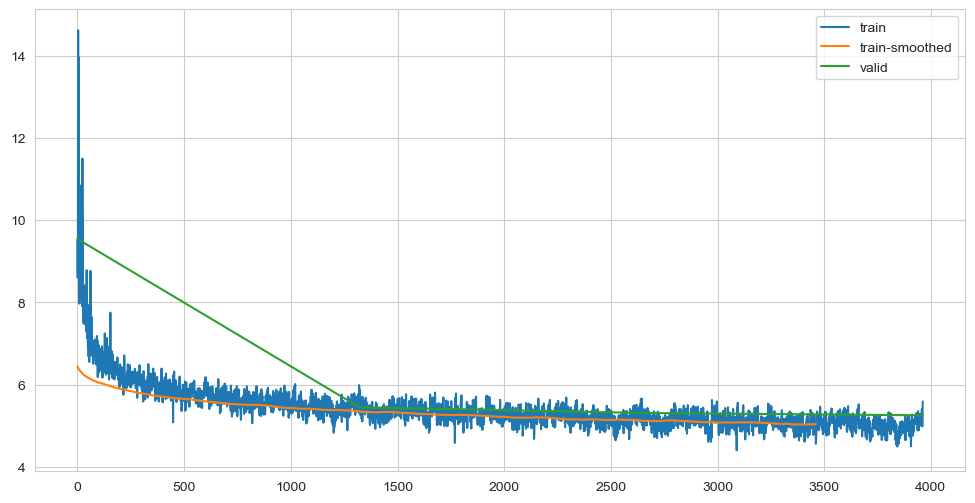

In [47]:
SMOOTHING_PERIOD = 500

plt.figure(figsize=(12, 6))

# строим полученные лоссы с каждого батча обучения
plt.plot(train_losses, label="train")

# получим сглаженные значения train_losses
smoothed = np.convolve(train_losses, np.ones(SMOOTHING_PERIOD) / SMOOTHING_PERIOD)

# строим сглаженные лоссы обучения
plt.plot(smoothed[SMOOTHING_PERIOD:-SMOOTHING_PERIOD], label="train-smoothed")

# строим полученные лоссы с каждой эвалюации
plt.plot(len(train_losses) / EPOCHS * np.arange(EPOCHS + 1), eval_losses, label="valid")

plt.legend()

plt.show()